In [4]:
import os
import shutil
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import yaml

!pip install ultralytics

from ultralytics import YOLO

In [9]:
# Define class names
class_names = ['open', 'short', 'mousebite', 'spur', 'copper', 'pin-hole']

# Set paths
dataset_path = '/content/drive/MyDrive/PCB data'
yolo_dataset_path = '/content/deepPCB_yolo'

# Create YOLO dataset directories
os.makedirs(yolo_dataset_path, exist_ok=True)
os.makedirs(os.path.join(yolo_dataset_path, 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join(yolo_dataset_path, 'images', 'val'), exist_ok=True)
os.makedirs(os.path.join(yolo_dataset_path, 'labels', 'train'), exist_ok=True)
os.makedirs(os.path.join(yolo_dataset_path, 'labels', 'val'), exist_ok=True)

In [10]:
def convert_pcb_to_yolo_format(txt_file, img_width, img_height):
    """Convert PCB annotation format to YOLO format."""
    yolo_annotations = []

    with open(txt_file, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue

        x1, y1, x2, y2, class_id = map(int, parts)

        # Skip background class (0)
        if int(class_id) == 0:
            continue

        # Convert to YOLO format (normalized center x, center y, width, height)
        # YOLO class ids are 0-indexed, but PCB starts at 1, so subtract 1
        yolo_class_id = int(class_id) - 1

        # Calculate center points and width, height
        center_x = ((x1 + x2) / 2) / img_width
        center_y = ((y1 + y2) / 2) / img_height
        width = abs(x2 - x1) / img_width
        height = abs(y2 - y1) / img_height

        yolo_annotations.append(f"{yolo_class_id} {center_x} {center_y} {width} {height}")

    return yolo_annotations

def prepare_dataset():
    """Prepare the dataset by converting annotations to YOLO format."""
    print("Preparing dataset...")

    # Read train/val split
    with open(os.path.join(dataset_path, 'trainval.txt'), 'r') as f:
        trainval_files = f.readlines()

    # Split trainval into train and validation sets (80% train, 20% val)
    random.shuffle(trainval_files)
    split_idx = int(len(trainval_files) * 0.8)
    train_files = trainval_files[:split_idx]
    val_files = trainval_files[split_idx:]

    # Process train files
    process_files(train_files, 'train')

    # Process validation files
    process_files(val_files, 'val')

    # Create dataset.yaml file
    create_yaml_config(len(train_files), len(val_files))

    print(f"Dataset prepared with {len(train_files)} training and {len(val_files)} validation samples")

def process_files(file_list, split):
    """Process files for a specific split (train or val)."""
    for idx, line in enumerate(tqdm(file_list, desc=f"Processing {split} set")):
        img_path, ann_path = line.strip().split()

        # Correct image path (add _test)
        img_filename = os.path.basename(img_path)
        img_basename, img_ext = os.path.splitext(img_filename)
        img_path = img_path.replace(img_filename, f"{img_basename}_test{img_ext}")

        # Full paths
        full_img_path = os.path.join(dataset_path, img_path)
        full_ann_path = os.path.join(dataset_path, ann_path)

        # Skip if files don't exist
        if not os.path.exists(full_img_path) or not os.path.exists(full_ann_path):
            continue

        # Get image dimensions
        img = cv2.imread(full_img_path)
        if img is None:
            continue

        img_height, img_width = img.shape[:2]

        # Convert annotation to YOLO format
        yolo_annotations = convert_pcb_to_yolo_format(full_ann_path, img_width, img_height)

        # Save image and label
        dest_img_path = os.path.join(yolo_dataset_path, 'images', split, f"{img_basename}.jpg")
        dest_lbl_path = os.path.join(yolo_dataset_path, 'labels', split, f"{img_basename}.txt")

        # Copy image
        shutil.copy(full_img_path, dest_img_path)

        # Save YOLO annotation
        with open(dest_lbl_path, 'w') as f:
            f.write('\n'.join(yolo_annotations))

        # Limit processing for testing (comment this out for full dataset)
        if idx > 0 and idx % 1000 == 0:
            print(f"Processed {idx} {split} images")

prepare_dataset()

Preparing dataset...


Processing val set: 100%|██████████| 200/200 [04:32<00:00,  1.36s/it]

Dataset prepared with 800 training and 200 validation samples


In [11]:
def create_yaml_config(train_count, val_count):
    """Create YAML configuration file for YOLOv8."""
    config = {
        'path': os.path.abspath(yolo_dataset_path),
        'train': os.path.join('images', 'train'),
        'val': os.path.join('images', 'val'),
        'names': {i: name for i, name in enumerate(class_names)},
        'nc': len(class_names)
    }

    with open(os.path.join(yolo_dataset_path, 'dataset.yaml'), 'w') as f:
        yaml.dump(config, f, default_flow_style=False)

In [13]:
def train_model():
    """Train YOLOv8 model on the dataset."""
    print("Training model...")

    # Initialize YOLOv8 model
    model = YOLO('yolov8n.pt')  # Use smaller model for Colab free tier

    # Train the model
    results = model.train(
        data=os.path.join(yolo_dataset_path, 'dataset.yaml'),
        epochs=30,
        imgsz=640,
        batch=16,  # Adjust batch size based on memory
        patience=5,
        device=0,
        project='pcb_defect_detection',
        name='yolov8n_pcb'
    )

    return model

def evaluate_model(model):
    """Evaluate the trained model."""
    print("Evaluating model...")

    # Validate the model
    metrics = model.val()

    # Print metrics
    print(f"mAP50: {metrics.box.map50:.4f}")
    print(f"mAP50-95: {metrics.box.map:.4f}")

    return metrics


model = train_model()
evaluate_model(model)

Training model...


100%|██████████| 6.25M/6.25M [00:00<00:00, 255MB/s]


Ultralytics 8.3.84 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/deepPCB_yolo/dataset.yaml, epochs=30, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=pcb_defect_detection, name=yolov8n_pcb, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, s

100%|██████████| 755k/755k [00:00<00:00, 95.4MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 287MB/s]


AMP: checks passed ✅


train: Scanning /content/deepPCB_yolo/labels/train... 800 images, 0 backgrounds, 0 corrupt: 100%|██████████| 800/800 [00:00<00:00, 2067.07it/s]


train: New cache created: /content/deepPCB_yolo/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/deepPCB_yolo/labels/val... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 1727.88it/s]

val: New cache created: /content/deepPCB_yolo/labels/val.cache


Plotting labels to pcb_defect_detection/yolov8n_pcb/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to pcb_defect_detection/yolov8n_pcb
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.16G      2.591      3.999      1.573        118        640: 100%|██████████| 50/50 [00:17<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        200       1368     0.0177      0.662      0.125     0.0663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.07G      1.609      2.264      1.102        190        640: 100%|██████████| 50/50 [00:15<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        200       1368      0.607      0.369      0.503       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.05G       1.51      1.784      1.067        175        640: 100%|██████████| 50/50 [00:14<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]


                   all        200       1368      0.638       0.59      0.622       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.05G      1.445      1.552      1.045        138        640: 100%|██████████| 50/50 [00:14<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        200       1368      0.703       0.58      0.652      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.03G      1.384      1.368      1.021        154        640: 100%|██████████| 50/50 [00:14<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        200       1368      0.861      0.794      0.897      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.04G      1.345      1.245       1.01        103        640: 100%|██████████| 50/50 [00:14<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

                   all        200       1368      0.883      0.816      0.907      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.13G      1.291      1.155     0.9951        159        640: 100%|██████████| 50/50 [00:14<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        200       1368      0.876      0.817      0.911      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.06G      1.271      1.132     0.9914        117        640: 100%|██████████| 50/50 [00:14<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        200       1368      0.917      0.858      0.943      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.03G      1.282        1.1     0.9886        139        640: 100%|██████████| 50/50 [00:14<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        200       1368      0.903       0.88      0.945      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.04G      1.179     0.9788     0.9648        159        640: 100%|██████████| 50/50 [00:14<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        200       1368      0.931      0.885      0.958      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.06G      1.194     0.9681     0.9622        117        640: 100%|██████████| 50/50 [00:17<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]


                   all        200       1368      0.912      0.885      0.945      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.03G      1.228      0.968     0.9697        158        640: 100%|██████████| 50/50 [00:14<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        200       1368       0.92      0.897      0.957      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.04G      1.168     0.9037     0.9509        141        640: 100%|██████████| 50/50 [00:14<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        200       1368      0.939      0.896       0.96      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.11G      1.152     0.8729     0.9512        137        640: 100%|██████████| 50/50 [00:14<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        200       1368      0.954      0.912      0.972      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.04G      1.121     0.8285     0.9413        138        640: 100%|██████████| 50/50 [00:14<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


                   all        200       1368      0.938      0.916      0.971      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.04G      1.141      0.828     0.9499        143        640: 100%|██████████| 50/50 [00:14<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        200       1368       0.94      0.904      0.956      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.14G      1.114     0.8213      0.943        123        640: 100%|██████████| 50/50 [00:14<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        200       1368      0.927       0.91      0.965      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.04G      1.086     0.7946     0.9411        140        640: 100%|██████████| 50/50 [00:14<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200       1368       0.95      0.923      0.975      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30       2.1G      1.077     0.7744     0.9358        160        640: 100%|██████████| 50/50 [00:14<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        200       1368      0.959      0.943       0.98      0.693
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 14, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



19 epochs completed in 0.097 hours.
Optimizer stripped from pcb_defect_detection/yolov8n_pcb/weights/last.pt, 6.2MB
Optimizer stripped from pcb_defect_detection/yolov8n_pcb/weights/best.pt, 6.2MB

Validating pcb_defect_detection/yolov8n_pcb/weights/best.pt...
Ultralytics 8.3.84 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


                   all        200       1368      0.949      0.915      0.972      0.715
                  open        170        262      0.968       0.92      0.984      0.703
                 short        140        201      0.907      0.876      0.947      0.633
             mousebite        162        263      0.963      0.901      0.971      0.677
                  spur        158        228      0.949      0.899      0.967       0.67
                copper        168        200      0.936      0.956       0.98      0.803
              pin-hole        174        214      0.971      0.939      0.985      0.802
Speed: 0.3ms preprocess, 5.1ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to pcb_defect_detection/yolov8n_pcb
Evaluating model...
Ultralytics 8.3.84 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/deepPCB_yolo/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


                   all        200       1368       0.95      0.915      0.973      0.716
                  open        170        262      0.968       0.92      0.984      0.706
                 short        140        201      0.907      0.876      0.947      0.635
             mousebite        162        263      0.963      0.897      0.971      0.676
                  spur        158        228      0.957      0.904      0.974      0.675
                copper        168        200      0.937      0.955       0.98      0.804
              pin-hole        174        214      0.971      0.939      0.985      0.802
Speed: 2.9ms preprocess, 6.1ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to pcb_defect_detection/yolov8n_pcb2
mAP50: 0.9735
mAP50-95: 0.7163


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e2efa926d10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

Visualizing predictions...

image 1/1 /content/deepPCB_yolo/images/val/92000108.jpg: 640x640 1 open, 1 short, 1 mousebite, 1 spur, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/deepPCB_yolo/images/val/13000093.jpg: 640x640 2 opens, 1 short, 2 mousebites, 2 spurs, 1 copper, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/deepPCB_yolo/images/val/77000031.jpg: 640x640 1 open, 1 mousebite, 2 coppers, 2 pin-holes, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/deepPCB_yolo/images/val/20085092.jpg: 640x640 3 opens, 1 spur, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/deepPCB_yolo/images/val/13000166.jpg: 640x640 2 mousebites, 2 pin-holes, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.3ms p

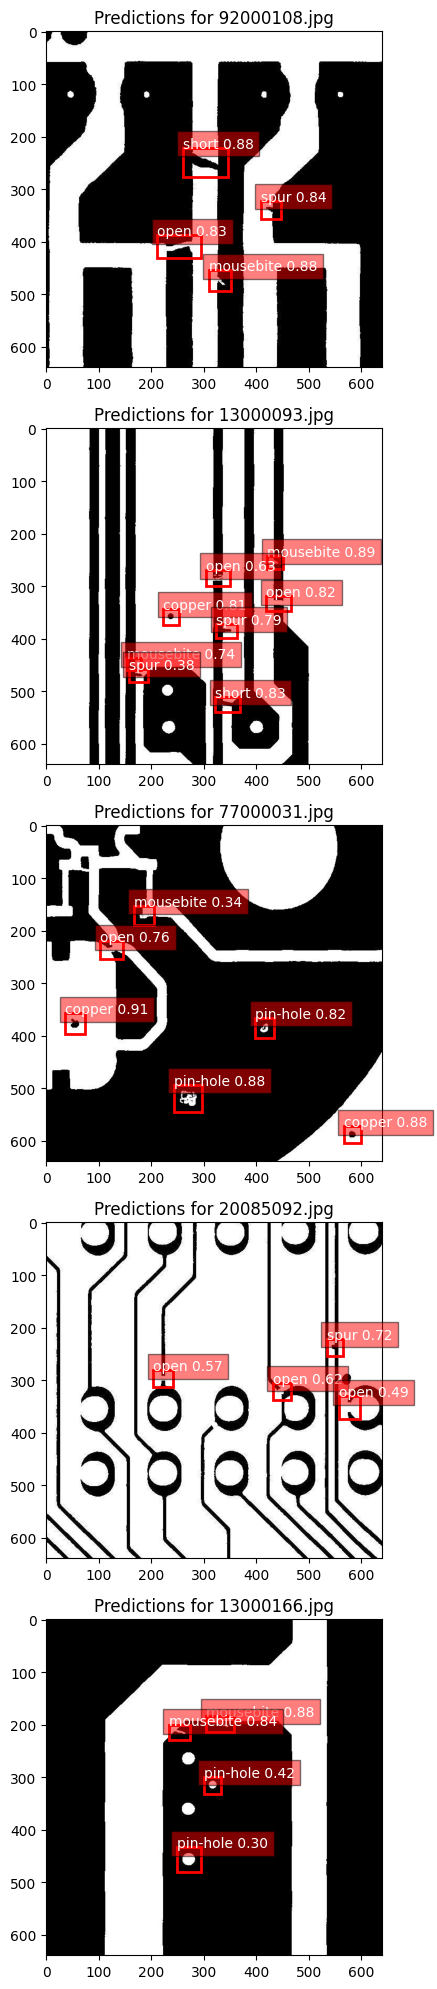

PCB defect detection model training completed!


In [15]:
def visualize_predictions(model, num_samples=5):
    """Visualize some predictions from the validation set."""
    print("Visualizing predictions...")

    val_img_path = os.path.join(yolo_dataset_path, 'images', 'val')
    val_images = os.listdir(val_img_path)

    if len(val_images) == 0:
        print("No validation images found")
        return

    # Select random images
    selected_images = random.sample(val_images, min(num_samples, len(val_images)))

    plt.figure(figsize=(20, 4 * num_samples))

    for i, img_name in enumerate(selected_images):
        # Get image path
        img_path = os.path.join(val_img_path, img_name)

        # Make prediction
        results = model.predict(img_path, conf=0.25)

        # Plot results
        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
        plt.title(f"Predictions for {img_name}")

        # Draw bounding boxes
        if len(results[0].boxes) > 0:
            # Move tensor to CPU before converting to numpy
            boxes_data = results[0].boxes.data.cpu().numpy()

            for det in boxes_data:
                x1, y1, x2, y2, conf, cls = det
                plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                                 fill=False, edgecolor='red', linewidth=2))
                plt.text(x1, y1, f"{class_names[int(cls)]} {conf:.2f}",
                        color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.tight_layout()
    plt.show()


visualize_predictions(model)

print("PCB defect detection model training completed!")

In [16]:
model.export(format='onnx')
print("Model exported to ONNX format")

Ultralytics 8.3.84 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'pcb_defect_detection/yolov8n_pcb/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 312.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 kB 311.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 179.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 148.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 275.4 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 17.9s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 

In [19]:
def infer_on_single_image(model, img_path):
    """Run inference on a single image."""
    results = model.predict(img_path, conf=0.25)

    # Display results
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 8))
    plt.imshow(img)

    # Draw bounding boxes
    if len(results[0].boxes) > 0:
        # Move tensor to CPU before converting to numpy
        boxes_data = results[0].boxes.data.cpu().numpy()

        for det in boxes_data:
            x1, y1, x2, y2, conf, cls = det
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                             fill=False, edgecolor='red', linewidth=2))
            plt.text(x1, y1, f"{class_names[int(cls)]} {conf:.2f}",
                    color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.title("PCB Defect Detection")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


image 1/1 /content/deepPCB_yolo/images/train/00041000.jpg: 640x640 1 open, 1 short, 1 mousebite, 2 spurs, 2 coppers, 3 pin-holes, 10.5ms
Speed: 2.8ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


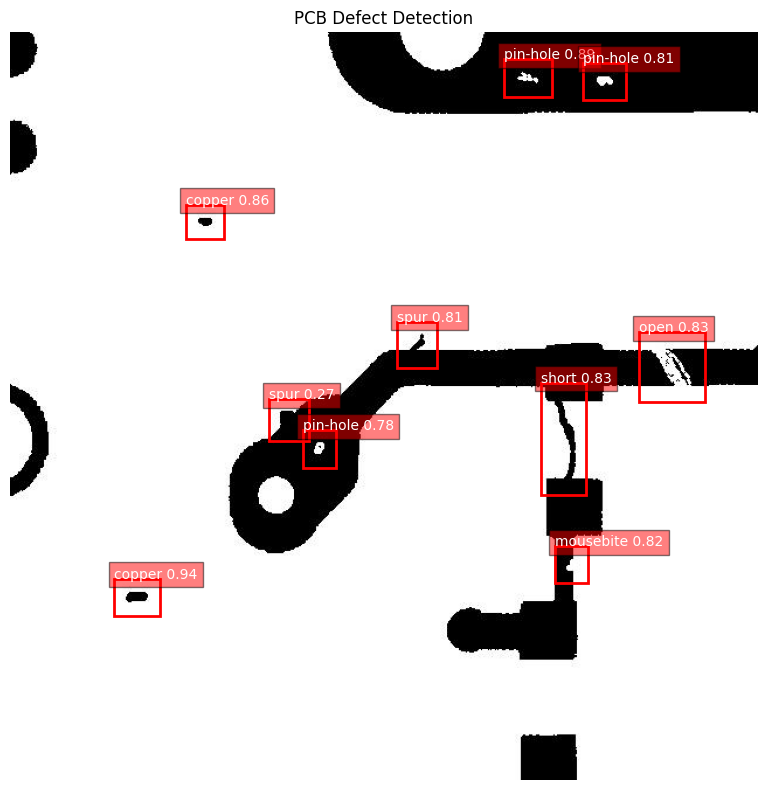

In [20]:
def load_and_infer(model_path, img_path):
    model = YOLO(model_path)
    infer_on_single_image(model, img_path)
    return model

# Example usage:
model = load_and_infer('/content/pcb_defect_detection/yolov8n_pcb/weights/best.pt', '/content/deepPCB_yolo/images/train/00041000.jpg')

In [24]:
import shutil

# Create the destination directory if it doesn't exist
destination_dir = "/content/drive/MyDrive/pcb_final"

# Copy the folders using shutil.copytree
shutil.copytree("/content/deepPCB_yolo", f"{destination_dir}/deepPCB_yolo", dirs_exist_ok=True)
shutil.copytree("/content/pcb_defect_detection", f"{destination_dir}/pcb_defect_detection", dirs_exist_ok=True)


'/content/drive/MyDrive/pcb_final/pcb_defect_detection'